## Eoin's Minimum(ish) Working Example

In [1]:
import oqupy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
oqupy.__version__

'0.4.0'

## System

A four level structure with two manifolds

Define system density matrix $\rho$

In [3]:
ρ_00 = np.array([[0. + 0*1j for _ in range(4)] for _ in range(4)])
ρ_11 = np.array([[0. + 0*1j for _ in range(4)] for _ in range(4)])
ρ_22 = np.array([[0. + 0*1j for _ in range(4)] for _ in range(4)])
ρ_33 = np.array([[0. + 0*1j for _ in range(4)] for _ in range(4)])
ρ_01 = np.array([[0. + 0*1j for _ in range(4)] for _ in range(4)])
ρ_02 = np.array([[0. + 0*1j for _ in range(4)] for _ in range(4)])
ρ_03 = np.array([[0. + 0*1j for _ in range(4)] for _ in range(4)])
ρ_12 = np.array([[0. + 0*1j for _ in range(4)] for _ in range(4)])
ρ_13 = np.array([[0. + 0*1j for _ in range(4)] for _ in range(4)])
ρ_23 = np.array([[0. + 0*1j for _ in range(4)] for _ in range(4)])

ρ_00[0][0] = 1 + 0*1j
ρ_11[1][1] = 1 + 0*1j
ρ_22[2][2] = 1 + 0*1j
ρ_33[3][3] = 1 + 0*1j

ρ_01[0][1] = 1 + 0*1j
ρ_02[0][2] = 1 + 0*1j
ρ_03[0][3] = 1 + 0*1j

ρ_12[1][2] = 1 + 0*1j
ρ_13[1][3] = 1 + 0*1j
ρ_23[2][3] = 1 + 0*1j

# unused
sminus_u = np.transpose(ρ_01)
splus_u = ρ_01
sminus_g = np.transpose(ρ_23)
splus_g = ρ_23

### Contstruct initial state

Initialise $\rho$ in the thermal density matrix, with temperature given by

$$
-\frac{\lambda_u}{k_B\log(a_0/a_1)}=20\ \text{K}
$$

In [4]:
kb = 0.131 # ħ = 1
temperature = 20*kb

λ_u = 1.68
λ_g = 0.282

a1 = 0.5/(0.5*(2+ np.exp(-λ_u/(temperature)) +np.exp(-λ_g/(temperature))))
a3 = 0.5/(0.5*(2+ np.exp(-λ_u/(temperature)) +np.exp(-λ_g/(temperature))))
a0 = a1*np.exp(-λ_u/(temperature))
a2 = a3*np.exp(-λ_g/(temperature))

print('trace = ')
print(a0+a1+a2+a3)
print('temp = ')
print(-λ_u/(kb*np.log(a0/a1)))

initial_state= a0*ρ_00 +  a1*ρ_11 +a2* ρ_22 +  a3*ρ_33

print('initial state = ')
print(initial_state)


trace = 
1.0
temp = 
20.0
initial state = 
[[0.15378379+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.29200445+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.26220731+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.29200445+0.j]]


### Coupling to the environment

Super ohmic spectral density with an exponential cutoff

Note, make sure that two is factored into luisa's definition above
$$
J(\omega) = 2 \alpha\frac{\omega^3}{\omega_c^2}\exp(-\frac{\omega}{\omega_c})
$$

Where $\alpha = 0.0275$, $\omega_c = 2\pi$

In [5]:
w_c = 2*np.pi #ω_c
alpha1 = 0.0275 # A of J(ω)
power_law = 1 # power law SD power

correlations = oqupy.PowerLawSD(alpha=alpha1,
                                zeta=power_law,
                                cutoff=w_c,
                                cutoff_type='exponential',
                                temperature=temperature)

tempo_parameters = oqupy.TempoParameters(dt=0.015, dkmax=50, epsrel=10**(-8))

/home/eobutler/dev/luisa_debug/oqupy/helpers.py:113: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


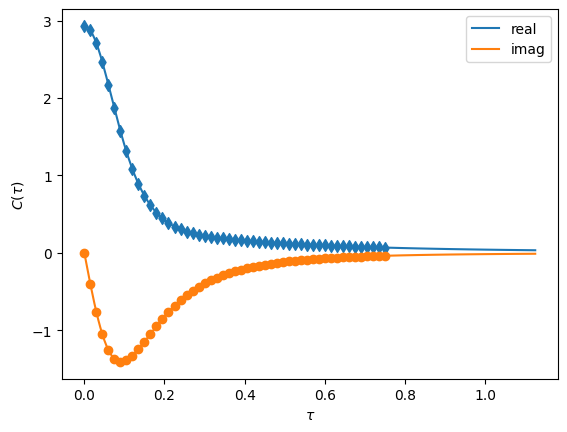

In [6]:
oqupy.helpers.plot_correlations_with_parameters(correlations,tempo_parameters)
plt.show()

In [7]:
Δ = 2.5
Ω_z = 0#2*1e-1
Ω_min = 0#02*1e-1
Ω_plus = 0#02*1e-1

# luisa what's this and where does this come from
ϵ = np.sqrt(0.0037/(2 * alpha1 * w_c**(1-power_law)))

OpPhon = (ρ_01 + ρ_23) + np.transpose(ρ_01 + ρ_23)
OpsDef = ρ_00 + ρ_11 - ρ_22 - ρ_33
bath = oqupy.Bath(ϵ*OpPhon + OpsDef, correlations)#bath = oqupy.Bath(ϵ*OpPhon + OpsDef, correlations)

# def hamiltonian_t(t): 
#     return 0.5*np.array([[-Δ + λ_u, 0, Ω_z, Ω_plus],[0, -Δ - λ_u, Ω_min, Ω_z],[Ω_z, Ω_min, Δ + λ_g, 0],[Ω_plus, Ω_z, 0, Δ - λ_g]])

hamiltonian = 0.5*np.array([[-Δ + λ_u, 0, Ω_z, Ω_plus],
                            [0, -Δ - λ_u, Ω_min, Ω_z],
                            [Ω_z, Ω_min, Δ + λ_g, 0],
                            [Ω_plus, Ω_z, 0, Δ - λ_g]])

system=oqupy.System(hamiltonian=hamiltonian)#,gammas=list(map(lambda x: x(0),γs)), lindblad_operators=list(map(lambda x: x(0),Ophot)))

sivtmpo=oqupy.Tempo(system=system,bath=bath,parameters=tempo_parameters,
              initial_state=initial_state,
              start_time=0.0)
              

In [8]:
compute_pt = True
if compute_pt:
    pt = oqupy.pt_tempo_compute(bath=bath,
                    parameters=tempo_parameters,
                    start_time=0.0,
                    end_time=0.5,)

    pt.export('luisa_pt.processTensor',overwrite=True)

--> PT-TEMPO computation:
100.0%   33 of   33 [########################################] 00:00:05
Elapsed time: 5.1s


In [9]:
pt = oqupy.import_process_tensor('luisa_pt.processTensor')

In [10]:
dyn = oqupy.compute_dynamics(
                process_tensor=pt,
                system=system,
                initial_state=initial_state,
                start_time=0
)

--> Compute dynamics:
100.0%   33 of   33 [########################################] 00:00:00
Elapsed time: 0.6s


In [11]:
sivtmpo.compute(end_time=0.5)

--> TEMPO computation:
100.0%   33 of   33 [########################################] 00:00:15
Elapsed time: 15.5s


In [12]:
dyn = sivtmpo.get_dynamics()

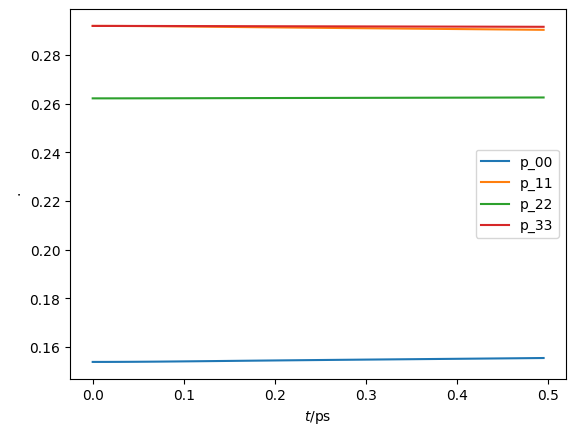

In [13]:
plt.plot(dyn.times,dyn.states[:,0,0].real, label="p_00")
plt.plot(dyn.times,dyn.states[:,1,1].real, label="p_11")
plt.plot(dyn.times,dyn.states[:,2,2].real, label="p_22")
plt.plot(dyn.times,dyn.states[:,3,3].real, label="p_33")

#plt.plot(t, (ρ_00 + ρ_11 + ρ_22 + ρ_33), label="sum")
#plt.plot(t, p_10.imag, label=r"$\Delta = $"+f"{delta:0.1f}")
plt.xlabel(r'$t/$ps')
plt.ylabel(r'$ . $')
#plt.ylim((0.0,1.0))
plt.legend()
plt.show()

In [14]:
#temperature at intial time
print(-λ_u/(kb*np.log(dyn.states[0,0,0].real/dyn.states[0,1,1].real)))
print(-λ_g/(kb*np.log(dyn.states[0,2,2].real/dyn.states[0,3,3].real)))

20.0
19.999999999999993


In [15]:
#temperature at final time
print(-λ_u/(kb*np.log(dyn.states[-1,0,0].real/dyn.states[-1,1,1].real)))
print(-λ_g/(kb*np.log(dyn.states[-1,2,2].real/dyn.states[-1,3,3].real)))

20.50932178730898
20.49924165717291


In [16]:
print(dyn.states[0,0,0].real + dyn.states[0,1,1].real)
print(dyn.states[0,2,2].real +dyn.states[0,3,3].real)
print(dyn.states[0,0,0].real + dyn.states[0,1,1].real + dyn.states[0,2,2].real +dyn.states[0,3,3].real)

0.44578824067344636
0.5542117593265538
1.0


In [17]:
print(dyn.states[-1,0,0].real + dyn.states[-1,1,1].real)
print(dyn.states[-1,2,2].real + dyn.states[-1,3,3].real)
print(dyn.states[-1,0,0].real + dyn.states[-1,1,1].real + dyn.states[-1,2,2].real + dyn.states[-1,3,3].real)

0.445787798775265
0.5542117762548222
0.9999995750300872


In [18]:
print(dyn.states[-1,0,0].real + dyn.states[-1,1,1].real)
print(dyn.states[-1,2,2].real + dyn.states[-1,3,3].real)
print(dyn.states[-1,0,0].real + dyn.states[-1,1,1].real + dyn.states[-1,2,2].real + dyn.states[-1,3,3].real)

0.445787798775265
0.5542117762548222
0.9999995750300872
